### Part 1 - a
Loading in the dataset and defining classification functions

In [153]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

iris = load_iris()

def TrainDataWithKFolds(estimators, folds):
    kfold = KFold(n_splits=10, random_state=11, shuffle=True)

    duck = {}
    
    #Now execute each model and return the 
    for name, obj in estimators.items():
        kfold = KFold(n_splits=folds, random_state=11, shuffle=True)
        scores = cross_val_score(estimator=obj, 
            X=iris.data, y=iris.target, cv=kfold)

        duck[name] = scores.mean()
        print(f'With k = {folds}, '
            f'{name:>20}: ' + 
            f'mean accuracy={scores.mean():.2%}; ' +
            f'standard deviation={scores.std():.2%}')

    return duck

### Part 1 - b & c
K- Closest Neighbor



Neural Network using multi-layer perceptron

In [154]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

estimators = {
    'KNeighborsClassifier': KNeighborsClassifier(), 
    'SGD': SGDClassifier(loss="hinge", penalty="l2", max_iter=1000),
    'GaussianNB': GaussianNB()}

twoFolds = TrainDataWithKFolds(estimators, 2)
twnentyFolds = TrainDataWithKFolds(estimators, 20)

maxClassifier = max(max(twoFolds, key=twoFolds.get), max(twnentyFolds, key=twnentyFolds.get))
    #estimators[maxClassifier], max(max(twoFolds.values()), max(twnentyFolds.values()))
print(f"The best estimator for this dataset is {estimators[maxClassifier]}")

With k = 2, KNeighborsClassifier: mean accuracy=95.33%; standard deviation=0.67%
With k = 2,                  SGD: mean accuracy=76.00%; standard deviation=12.00%
With k = 2,           GaussianNB: mean accuracy=95.33%; standard deviation=3.33%
With k = 20, KNeighborsClassifier: mean accuracy=96.70%; standard deviation=5.74%
With k = 20,                  SGD: mean accuracy=81.79%; standard deviation=20.30%
With k = 20,           GaussianNB: mean accuracy=94.91%; standard deviation=7.39%
The best estimator for this dataset is KNeighborsClassifier()


### Part 1 - d
create confusion matrix

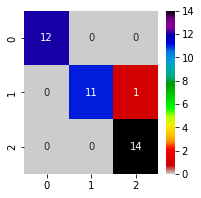

In [155]:
#We need pandas for the DateFrame, seaborn for the heatmap, and plt for the figure and color map 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def TrainAndClassify(classifier):
    xTrain, xTest, yTrain, yTest = train_test_split(iris.data, iris.target, random_state=11) #add random state for reproducibility \n,

    classifier.fit(X=xTrain, y=yTrain)
    predictedLabels = classifier.predict(X=xTest)
    expectedLabels = yTest #We also require our expected labels for future analysis.

    wrong = [(p, e) for (p, e) in zip(predictedLabels, expectedLabels) if p != e]

    return (predictedLabels, expectedLabels)

result = TrainAndClassify(estimators[maxClassifier])

confusion = confusion_matrix(y_true=result[0], y_pred=result[1])
confusion_df = pd.DataFrame(confusion, index=range(3), columns=range(3))

figure = plt.figure(figsize=(3, 3))
axes = sns.heatmap(confusion_df, annot=True, 
                   cmap='nipy_spectral_r') 

### Part 2 - a
setup parameters and tokens

In [196]:
import tweepy

import os

#Variables that contains the user credentials to access Twitter API 
access_token = "1438524083554107393-v2J4KHgxxDkkpaPvQVp38cl463s6JS"
access_token_secret = "5DcOfn52PLUrhVKbcBxdY38EcRJQixgOA6xfnaoRwqZwC"
consumer_key = "DqmMnt4JIIRAScxx7KwoPvJ1d"
consumer_secret = "MV1Y2QV4OaLaU0qiPQEVAxzpLZqTlftt7EahLEET3MjD0l4PpN"

auth = tweepy.OAuthHandler(consumer_key,
                           consumer_secret) #Set up the app keys
auth.set_access_token(access_token,
                      access_token_secret) #set up your user tokens

api = tweepy.API(auth, wait_on_rate_limit=True, 
                 wait_on_rate_limit_notify=True) #ALWAYS use wait_on_rate_limit to prevent yourself from getting blocked

### Part 2 - b
Start finding tweets from Cincinnati and sort them

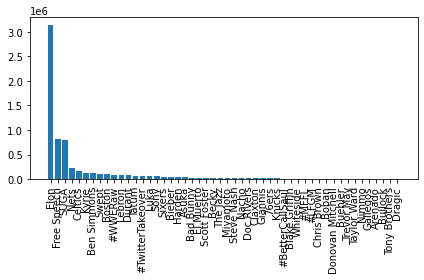

In [254]:
from operator import itemgetter

#WOEID for Cincinnati = 2380358
cincyTrendsComp = api.trends_place(id=2380358)
api.rate_limit_status()['resources']['trends']['/trends/place']
cincyTrends = cincyTrendsComp[0]['trends']

#assign 5000 to all trends that have no valme (i.e. they are < 10000)
for trend in cincyTrends:
    if (trend['tweet_volume'] == None):
        trend['tweet_volume'] = 5000

cincyTrends.sort(key=itemgetter('tweet_volume'), reverse=True) #sort world trends by descending volume


plt.bar(x=[t['name'] for t in cincyTrends], height=[t['tweet_volume'] for t in cincyTrends])

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(fname="tweetsInCincy.png", facecolor='white')
plt.show()

### Part 2 - c & d
Find  20 tweets of top 3 trends; preprocess and find sentiment

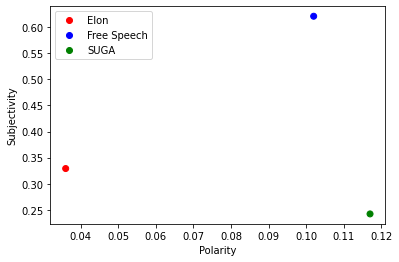

In [255]:
from textblob import TextBlob
from preprocessor.api import clean
from matplotlib.colors import ListedColormap
firstTrend = cincyTrends[0]
secondTrend = cincyTrends[1]
thirdTrend = cincyTrends[2]

def returnTweets(tweets):
    returnTweets = []
    for tweet in tweets:
            returnTweets.append(tweet.text)
    return returnTweets

def findSentiment(tweets):
    sentiments = []
    for tweet in tweets:
        txtBlb = TextBlob(clean(tweet))
        sentiments.append({"pol": txtBlb.sentiment.polarity, "sub": txtBlb.sentiment.subjectivity})

    return sentiments

def findSentimentStats(sentimentList):
    polaritySum = 0
    subjectivitySum = 0
    totalTweets = 0
    for sent in sentimentList:
        totalTweets += 1
        polaritySum += sent['pol']
        subjectivitySum += sent['sub']

    return(round(polaritySum/totalTweets,3), round(subjectivitySum/totalTweets,3))

firstTrendSentiments = findSentiment(returnTweets(api.search(q=firstTrend['name'], count=20)))
secondTrendSentiments = findSentiment(returnTweets(api.search(q=secondTrend['name'], count=20)))
thirdTrendSentiments = findSentiment(returnTweets(api.search(q=thirdTrend['name'], count=20)))

stats = {}
stats[firstTrend['name']] = findSentimentStats(firstTrendSentiments)
stats[secondTrend['name']] = findSentimentStats(secondTrendSentiments)
stats[thirdTrend['name']] = findSentimentStats(thirdTrendSentiments)


values = [0, 1, 2]
colors = ListedColormap(['r','b','g'])
scatter = plt.scatter([stats[firstTrend['name']][0], stats[secondTrend['name']][0], stats[thirdTrend['name']][0]], [stats[firstTrend['name']][1], stats[secondTrend['name']][1], stats[thirdTrend['name']][1]],c=values, cmap=colors)
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.legend(handles=scatter.legend_elements()[0], labels=[firstTrend['name'],secondTrend['name'], thirdTrend['name']])

plt.savefig(fname="sentimentAnalysis.png", facecolor='white')
